In [1]:
import ast
import torch
import numpy as np
import os, sys
from thop import profile
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary

from Utils import *
from Models import *

In [2]:
checkpoint = torch.load('./Checkpoint/micronet_ver2.t7')

In [3]:
checkpoint.keys()

dict_keys(['net_init', 'net1', 'net2', 'net3', 'net4', 'train_losses', 'train_accuracy', 'test_losses', 'test_accuracy', 'flops_params', 'Score'])

In [4]:
net = MicroNet(num_classes = 100, add_se = True, Activation = 'HSwish')

In [5]:
net.load_state_dict(checkpoint['net4'], strict = False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [18]:
net.float()
conv1 = []
conv3 = []
conv2 = []
for name, p in net.named_parameters():
    if 'layer' in name:
        if 'conv1' in name:
            print(name)
            print('in channels: {}, out channels: {}, cur std: {:.4f}'.format(p.shape[1],p.shape[0], torch.std(p.flatten().cpu().detach()).item()))
            conv1.append((p.shape[1],p.shape[0], torch.std(p.flatten().cpu().detach()).item()))
        elif 'conv3' in name:
            print(name)
            print('in channels: {}, out channels: {}, cur std: {:.4f}'.format(p.shape[1],p.shape[0], torch.std(p.flatten().cpu().detach()).item()))
            conv3.append((p.shape[1],p.shape[0], torch.std(p.flatten().cpu().detach()).item()))
        elif 'conv2' in name:
            print(name)
            print('in channels: {}, out channels: {}, cur std: {:.4f}'.format(p.shape[1],p.shape[0], torch.std(p.flatten().cpu().detach()).item()))
            conv2.append((p.shape[1],p.shape[0], torch.std(p.flatten().cpu().detach()).item()))

layers.0.conv1.weight
in channels: 32, out channels: 80, cur std: 0.1118
layers.0.conv2.weight
in channels: 1, out channels: 80, cur std: 0.4867
layers.0.conv3.weight
in channels: 80, out channels: 16, cur std: 0.1452
layers.1.conv1.weight
in channels: 16, out channels: 40, cur std: 0.1588
layers.1.conv2.weight
in channels: 1, out channels: 40, cur std: 0.5764
layers.1.conv3.weight
in channels: 40, out channels: 16, cur std: 0.1872
layers.2.conv1.weight
in channels: 16, out channels: 40, cur std: 0.1618
layers.2.conv2.weight
in channels: 1, out channels: 40, cur std: 0.4907
layers.2.conv3.weight
in channels: 40, out channels: 32, cur std: 0.1786
layers.3.conv1.weight
in channels: 32, out channels: 80, cur std: 0.1117
layers.3.conv2.weight
in channels: 1, out channels: 80, cur std: 0.3914
layers.3.conv3.weight
in channels: 80, out channels: 32, cur std: 0.1347
layers.4.conv1.weight
in channels: 32, out channels: 80, cur std: 0.1120
layers.4.conv2.weight
in channels: 1, out channels: 80,

In [16]:
conv1

[(32, 80, 0.11183091253042221),
 (16, 40, 0.15884745121002197),
 (16, 40, 0.1618334800004959),
 (32, 80, 0.11165979504585266),
 (32, 80, 0.11203133314847946),
 (48, 120, 0.09172869473695755),
 (48, 120, 0.09202772378921509),
 (48, 120, 0.09786012768745422),
 (72, 180, 0.07543502002954483),
 (72, 180, 0.07595973461866379),
 (72, 180, 0.07603191584348679),
 (72, 180, 0.0766792818903923),
 (72, 180, 0.08187384903430939),
 (80, 200, 0.07209087908267975),
 (88, 220, 0.06902409344911575),
 (88, 220, 0.0702759176492691)]

In [20]:
conv3

[(80, 16, 0.14524002373218536),
 (40, 16, 0.18716874718666077),
 (40, 32, 0.1785612404346466),
 (80, 32, 0.1347312331199646),
 (80, 48, 0.1237325444817543),
 (120, 48, 0.10695267468690872),
 (120, 48, 0.10852937400341034),
 (120, 72, 0.1106489822268486),
 (180, 72, 0.08645673841238022),
 (180, 72, 0.08740988373756409),
 (180, 72, 0.08668553829193115),
 (180, 72, 0.08747361600399017),
 (180, 80, 0.09637001901865005),
 (200, 88, 0.08105547726154327),
 (220, 88, 0.07930204272270203),
 (220, 106, 0.0776604413986206)]

In [27]:
block = []
for i in range(16):
    if i ==2 or i==7 or i==12:
        s=2
    else:
        s=1
    block.append([conv1[i][0], conv1[i][1], conv3[i][1], s, conv1[i][2], conv2[i][2], conv3[i][2]])
    #in_channel, expanded , out_channel, stride, sigma1, sigma2, sigma3
block = np.asarray(block)

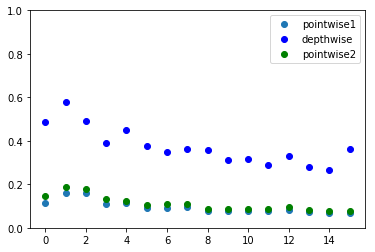

In [112]:
plt.plot(block[:,4], 'o', label = 'pointwise1')
plt.plot(block[:,5] , 'bo', label = 'depthwise')
plt.plot(block[:,6], 'go', label = 'pointwise2')
plt.ylim(0,1)
plt.legend()

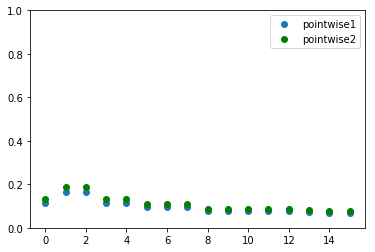

In [116]:
plt.plot(0.65 / np.sqrt(block[:,0]), 'o', label = 'pointwise1')
#plt.plot(block[:,5] , 'bo', label = 'depthwise')
plt.plot(1.18 / np.sqrt(block[:,1]), 'go', label = 'pointwise2')
plt.ylim(0,1)
plt.legend()

In [105]:
np.mean(block[:,5] * block[:,1]/block[:,0])

0.14991070777177812

In [69]:
block[0,4], np.mean(block[1:3,4]), np.mean(block[3:5,4]), np.mean(block[5:8,4]), np.mean(block[8:13,4]), np.mean(block[13:,4])

(0.11183091253042221,
 0.16034046560525894,
 0.11184556409716606,
 0.09387218207120895,
 0.07719596028327942,
 0.07046363006035487)

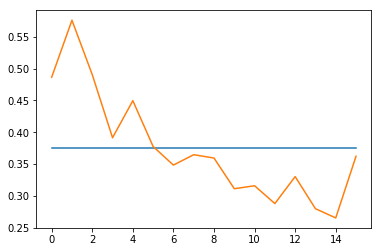

In [109]:
plt.plot(block[:,1]/block[:,0] * 0.15)
plt.plot(block[:,5])

In [119]:
0.65 / 0.55

1.1818181818181817

In [118]:
1.18

0.834386001800126